In [1]:
import os
import pandas as pd
import numpy as np
import json
from google.colab import files
import io
from keras import layers
from keras import models
from keras import applications
from keras import optimizers
import keras

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!unzip -q "/content/drive/My Drive/Tadkamadla, Aashrith Sai"

I have checked if the file contains any file ending with **.json** and extracted all the **pose_keypoints_2d** and appended them into a data frame. I have taken only the co-ordinate values and not the probability of prediction from the openpose output.


In [0]:
i=2
path='/content/drive/My Drive/positive samples/video3.json'
#path='/content/13'
json_files=[pos_json for pos_json in os.listdir(path) if pos_json.endswith('.json')]
print('Found: ',len(json_files),'json keypoint frame files')
a=json.load(open(path+'/'+json_files[0]))
b=a['people']
q=b[0]['pose_keypoints_2d']
s=[p for p in q if p>1]
train=pd.DataFrame([s])
for j in range(1,len(json_files)):
    a=json.load(open(path+'/'+json_files[j]))
    b=a['people']
    if len(b)>0:
        q=b[0]['pose_keypoints_2d']
        s=[p for p in q if p>1]
        s=pd.DataFrame([s])
        train=train.append(s,ignore_index=True,sort=False)
    else:
        continue

Found:  3908 json keypoint frame files


The next code is used to clean the data and I have used **method='ffill'** to get the same values as the previous rows if there are NaN values. I have also handled the case where the pose_keypoints_2d are detected to be less than 50 features. I have made them equal to zero as often the keypoints of the toe are not properly detected and my model is not going to get affected by these values. 

In [0]:
train=train.fillna(method='ffill')
train=train.fillna(0)
y,x=train.shape
s=np.zeros(y)
s=pd.DataFrame(s)

for i in range(50):
    y,x=train.shape
    if x!=50:
        train[x]=s
        x=x+1
    if y<90:
        train=train.append(train.iloc[y-1],ignore_index=True,sort=False)

for i in range(50):
    train.iloc[:,i]=train.iloc[:,i]/train.iloc[:,i].max()

In [0]:
train=train.fillna(method='ffill')
train=train.fillna(0)
train

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
0,0.709859,0.724448,0.659839,0.864325,0.624714,0.659747,0.566257,0.548671,0.598719,0.460813,0.789954,0.783035,0.608083,0.838451,0.457673,0.845093,0.491378,0.800242,0.496841,0.671168,0.292729,0.563930,0.079499,0.599489,0.505866,0.698839,0.329074,0.707865,0.079309,0.715352,0.882192,0.683642,0.897476,0.742714,0.879613,0.856714,0.066875,0.924109,0.025320,0.706044,0.323042,0.732412,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.711736,0.699429,0.659813,0.864258,0.619263,0.668362,0.560340,0.557383,0.598605,0.442344,0.799170,0.782822,0.603672,0.828426,0.451171,0.822828,0.495785,0.800117,0.496861,0.666893,0.299414,0.563935,0.079483,0.599468,0.514909,0.695387,0.329108,0.707766,0.077084,0.718698,0.882169,0.679411,0.895286,0.722176,0.881859,0.839759,0.064597,0.924122,0.025296,0.710259,0.311824,0.724092,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.706211,0.694943,0.659813,0.859771,0.617510,0.676857,0.558424,0.586556,0.596106,0.438580,0.801484,0.772639,0.605811,0.818207,0.449010,0.784971,0.482531,0.809030,0.490172,0.683706,0.299378,0.563926,0.079543,0.599490,0.494561,0.698693,0.324576,0.704572,0.104173,0.712117,0.879943,0.670980,0.890698,0.709792,0.879706,0.827397,0.004944,0.696425,0.330551,0.731340,0.311824,0.724092,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.702557,0.690748,0.661703,0.864284,0.615695,0.702588,0.558341,0.603682,0.596043,0.446025,0.803751,0.762267,0.603687,0.794641,0.459799,0.753375,0.498006,0.808998,0.505803,0.683701,0.310504,0.563895,0.079510,0.599486,0.508114,0.695296,0.313371,0.704521,0.079362,0.715444,0.877679,0.662741,0.883960,0.705524,0.881836,0.822871,0.066929,0.924228,0.025341,0.689287,0.311597,0.728162,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.702432,0.686544,0.661741,0.864271,0.615664,0.711434,0.564285,0.637360,0.596093,0.464562,0.803727,0.755269,0.605881,0.767752,0.457717,0.718482,0.486963,0.809025,0.494629,0.687900,0.308274,0.567284,0.081766,0.599515,0.496847,0.691929,0.322325,0.704469,0.153828,0.721976,0.877594,0.658510,0.883852,0.697350,0.879659,0.818589,0.066929,0.924228,0.025341,0.689287,0.311597,0.728162,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3878,0.715352,0.796485,0.665541,0.868823,0.630140,0.651158,0.560409,0.531945,0.578475,0.460843,0.799107,0.803559,0.623562,0.848508,0.477350,0.797594,0.500220,0.831284,0.508008,0.688074,0.279307,0.563895,0.077282,0.596222,0.514983,0.722687,0.315618,0.711149,0.081575,0.708828,0.891157,0.750333,0.899766,0.813614,0.888675,0.721832,0.894588,0.890498,0.031115,0.718673,0.323173,0.724106,0.459747,0.76577,0.583072,0.930108,0.547859,0.972056,0.659989,0.999983
3879,0.715421,0.792523,0.665502,0.868755,0.628313,0.655333,0.560424,0.531941,0.583497,0.430979,0.801421,0.803565,0.614719,0.845139,0.477332,0.772192,0.498018,0.822380,0.505793,0.683748,0.285977,0.563859,0.079517,0.596212,0.514934,0.709044,0.320078,0.707796,0.079315,0.712125,0.893405,0.750043,0.899913,0.813464,0.884175,0.717522,0.901451,0.890439,0.272043,0.882370,0.334573,0.765815,0.459740,0.77016,0.583072,0.930108,0.547859,0.972056,0.659989,0.999983
3880,0.715421,0.792529,0.663703,0.855333,0.626486,0.668115,0.566260,0.548814,0.588576,0.412342,0.803743,0.789853,0.619114,0.825093,0.479483,0.724969,0.484749,0.831062,0.496844,0.687943,0.297143,0.563956,0.081789,0.596194,0.496771,0.705642,0.313337,0.704537,0.081653,0.712062,0.891149,0.745847,0.899874,0.813283,0.881906,0.700786,0.901436,0.886230,0.025309,0.697693,0.357529,0.732417,0.459740,0.77016,0.583072,0.930108,0.547859,0.972056,0.659989,0.999983
3881,0.715402,0.779661,0.665508,0.8642

I have given one output for 90 frames and hence always taken the input data as multiples of 90.

Loading the data and Reshaping the values as **(Samples,Timesteps,Features)** using numpys reshape method

In [0]:
finalx=pd.read_csv('../content/x.csv')
finaly=np.loadtxt('../content/finaly', delimiter=',')
valx=pd.read_csv('../content/valx.csv')
valy=np.loadtxt('../content/valy', delimiter=',')

In [0]:
finalx=finalx.fillna(method='ffill')

In [5]:
len(finaly)

80010

In [0]:
#finalx=trainx.iloc[:len(finaly),:]
X=finalx.values
X=X.reshape(int(len(finaly)/45),45,30)
#Y=np.array(finaly)
#Y=Y.reshape(len(finaly),1)

In [0]:
Y=finaly
Y=Y.reshape(int(len(finaly)/45),45,1)


In [0]:
x=valx.values
x=x.reshape(int(len(valy)/45),45,30)

In [0]:
y=valy
y=y.reshape(int(len(valy)/45),45,1)

In [49]:
x.shape

(400, 45, 30)

I have used callbacks for **model checkpointing** and **early stopping**

In [0]:
from keras.callbacks import EarlyStopping
from keras import regularizers
import tensorflow as tf
checkpoint_path='/content/weights.{epoch:02d}-{val_loss:.2f}.hdf5'
callbacks_list=tf.keras.callbacks.ModelCheckpoint(checkpoint_path,save_weights_only=False,save_best_only=True,monitor='loss')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=30)

**Model Architecture**

In [0]:
import tensorflow as tf
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(units=45,return_sequences=True,input_shape=(45,30)))
model.add(tf.keras.layers.LSTM(units=45,return_sequences=True,input_shape=(45,30)))
model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dropout(0.2)))
model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(units=90,activation='relu')))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dropout(0.2)))
model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(units=1, activation='sigmoid')))

I have used Adam optimizer and have manually checked the learning rate and selected 0.0001 as the best fit.

In [0]:
adam=tf.keras.optimizers.Adam(clipnorm=1,lr=0.002, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(optimizer=adam,loss='binary_crossentropy',metrics=['accuracy'])

In [0]:
X_train=tf.convert_to_tensor(X, np.float32)
X_test=tf.convert_to_tensor(x, np.float32)
y_train=tf.convert_to_tensor(Y)
y_test=tf.convert_to_tensor(y, np.float32)

In [58]:
X_train.shape

TensorShape([1778, 45, 30])

Training the model to 500 epochs using the batch size of 5

In [60]:
history=model.fit(X_train,y_train,epochs=500,batch_size=5,validation_data=(x,y),callbacks=[callbacks_list])

Epoch 1/500
356/356 [==============================] - 13s 37ms/step - loss: 0.4258 - accuracy: 0.7909 - val_loss: 0.6033 - val_accuracy: 0.6431
Epoch 2/500
356/356 [==============================] - 13s 37ms/step - loss: 0.4130 - accuracy: 0.7980 - val_loss: 0.5905 - val_accuracy: 0.6413
Epoch 3/500
356/356 [==============================] - 13s 37ms/step - loss: 0.4141 - accuracy: 0.7842 - val_loss: 0.6929 - val_accuracy: 0.6221
Epoch 4/500
356/356 [==============================] - 13s 37ms/step - loss: 0.4147 - accuracy: 0.7964 - val_loss: 0.6579 - val_accuracy: 0.6155
Epoch 5/500
356/356 [==============================] - 13s 37ms/step - loss: 0.4210 - accuracy: 0.7979 - val_loss: 0.6679 - val_accuracy: 0.5867
Epoch 6/500
356/356 [==============================] - 13s 38ms/step - loss: 0.4333 - accuracy: 0.7912 - val_loss: 0.9803 - val_accuracy: 0.6182
Epoch 7/500
356/356 [==============================] - 14s 39ms/step - loss: 0.4338 - accuracy: 0.7855 - val_loss: 0.6982 - val_ac

In [61]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 45, 45)            13680     
_________________________________________________________________
lstm_13 (LSTM)               (None, 45, 45)            16380     
_________________________________________________________________
time_distributed_24 (TimeDis (None, 45, 45)            0         
_________________________________________________________________
time_distributed_25 (TimeDis (None, 45, 90)            4140      
_________________________________________________________________
batch_normalization_6 (Batch (None, 45, 90)            360       
_________________________________________________________________
time_distributed_26 (TimeDis (None, 45, 90)            0         
_________________________________________________________________
time_distributed_27 (TimeDis (None, 45, 1)            

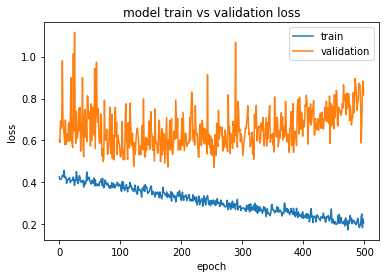

In [62]:
import matplotlib.pyplot as pyplot
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

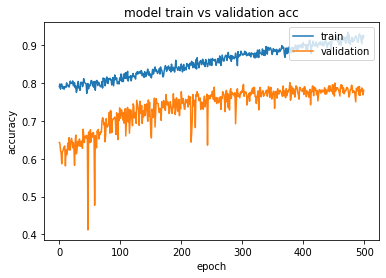

In [63]:
pyplot.plot(history.history['accuracy'])
pyplot.plot(history.history['val_accuracy'])
pyplot.title('model train vs validation acc')
pyplot.ylabel('accuracy')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

In [0]:
model.save('../content/wts.h5')

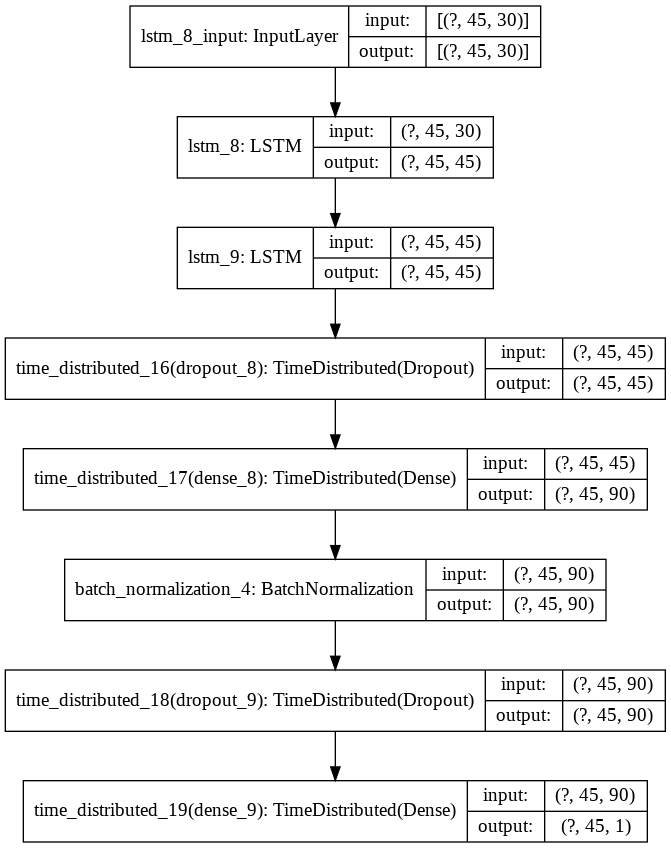

In [47]:

from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)